# Analysis of Land Surface Temperature (LST) across Varying Urban Land Covers in Minneapolis, Minnesota

There are three main goals of this project.
1. To determine and quantify the relationships between land cover and land surface temperature (LST), a key variable that will allow for an examination of the Urban Heat Island (UHI) effect across the City of Minneapolis.
2. To specifically examine the role that green spaces play in combatting UHI effects in the study area.
3. To create a method to run ANOVA in Python with summary statistics as the only input.

## 1. Data Processing and Exploration

In the following code blocks, the data will be downloaded, processed, and briefly explored. All necessary Python modules will also be imported.

In [1]:
# Importing Modules
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import f
import matplotlib.pyplot as plt
import rasterio as rio
from rasterstats import zonal_stats as zs
from rasterio.plot import show
from rasterio.plot import show_hist
import fiona
import folium
import json

%matplotlib inline
plt.style.use("seaborn-dark")

In [2]:
# Read in LST Rasters
b10_20210618 = rio.open("/Users/lukezaruba/Desktop/SpatialDBGit/mplsUHI/mpls_LC08_L2SP_027029_20210618_20210628_02_T1_ST_TRAD.tif")

"""
Other raster datasets:
b10_20210720 = rio.open("/Users/lukezaruba/Desktop/SpatialDBGit/mplsUHI/LC08_L2SP_027029_20210720_20210729_02_T1_ST_TRAD.TIF")
b10_20210922 = rio.open("/Users/lukezaruba/Desktop/SpatialDBGit/mplsUHI/LC08_L2SP_027029_20210922_20210930_02_T1_ST_TRAD.TIF")
"""

# Printing Metadata
print("Image b10_20210618 Metadata: " + "\n")

[print(str(i) + ": " + str(b10_20210618.meta[i])) for i in b10_20210618.meta]

Image b10_20210618 Metadata: 

driver: GTiff
dtype: int16
nodata: -9999.0
width: 356
height: 596
count: 1
crs: EPSG:32615
transform: | 30.00, 0.00, 473985.00|
| 0.00,-30.00, 4988715.00|
| 0.00, 0.00, 1.00|


[None, None, None, None, None, None, None, None]

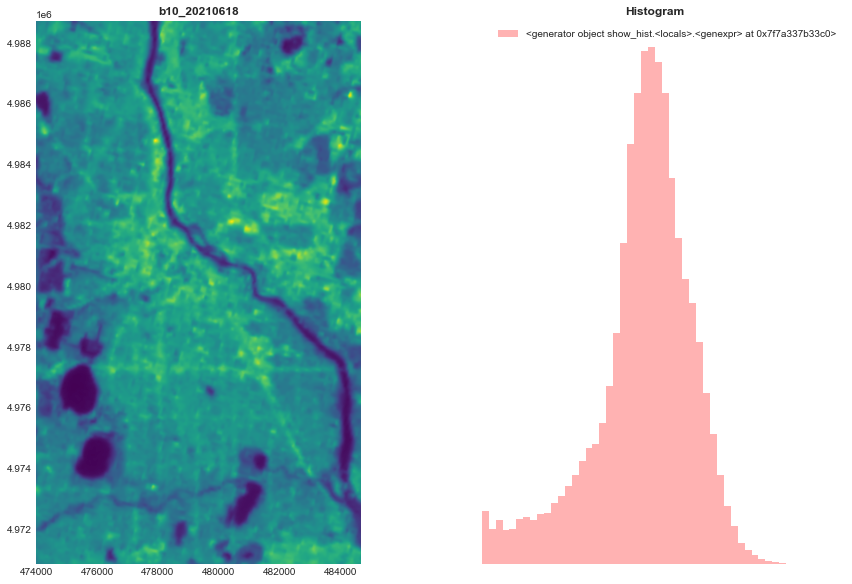

In [3]:
# Plotting Raster Images
fig, (aximg, axhist) = plt.subplots(1, 2, figsize=(15,10))

show((b10_20210618, 1), ax=aximg, cmap='viridis', title="b10_20210618")

show_hist(b10_20210618, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)

# Displaying Rasters
plt.axis('off')
plt.show()

NOTE: The map above shows the raw Landsat 8 band 10 imagery from June 18th, 2021. Band 10 shows the thermal portion of the electromagnetic spectrum, meaning that we are seeing "heat" values. The histogram on the right also shows how these pixel values are distributed.

## 2. Zonal Statistics
The following section is running a zonal statistics analysis on LST data and landcover data, meaning that summary statistics are being calculating for the LST values that are within the different landcover classes. After this, the raw DN values are being converted to brightness temperature (BT) values in degrees Fahrenheit. It should be noted that BT values are NOT the same as LST values or air temperature values, which is apparent when seeing that the values in degrees Fahrenheit are negative in the middle of summer. Using LST values was too data-intensive and  time-consuming for the purpose of this analysis, so BT values will serve the same purpose.

<AxesSubplot:title={'center':'Landcover Data'}>

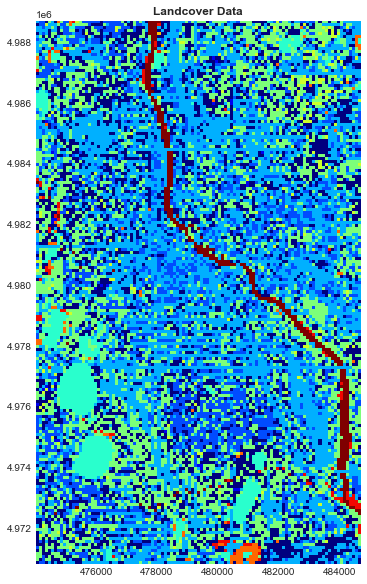

In [4]:
# Displaying Landcover Data from Source
""" 
NOTE: This was downsampled and vectorized in QGIS (I didn't have enough time to learn GDAL!).
      For the purposes of visualization, I will display the original raster dataset, clipped
      to the City of Minneapolis, here.
"""
landcover_rast = rio.open("/Users/lukezaruba/Desktop/SpatialDBGit/mplsUHI/Preprocessing/mpls_lc_100m.tif")
    
fig, aximg = plt.subplots(1, 1, figsize = (10, 10))

show((landcover_rast, 1), ax = aximg, cmap = "jet", title = "Landcover Data")

In [5]:
# Calculating Zonal Statistics
stats = zs("/Users/lukezaruba/Desktop/SpatialDBGit/mplsUHI/mpls_ls_30m_vector_dissolved.shp",
           "/Users/lukezaruba/Desktop/SpatialDBGit/mplsUHI/mpls_LC08_L2SP_027029_20210618_20210628_02_T1_ST_TRAD.tif",
           stats=["min", "max", "percentile_25.0", "percentile_75.0", "median", "mean", "std", "count"])

In [6]:
# Start of Creating Tool to Convert DN to LST

def generateBT(DN, Ml, Al, K1, K2):
    """Given a DN value and other necessary values from metadata, will convert to Brightness Temperature (BT)."""
    
    # Calculating TOA Reflectance
    TOA = (Ml * DN) + Al
    
    # Calculating BT (in °C)
    BT = (K2 / (np.log((K1 / TOA) + 1))) - 273.15
    
    # Converting BT from °C to °F
    F = (BT * (9/5)) + 32
    
    return F
    
def calculations(zonalStatsList, Ml, Al, K1, K2):
    """Given an output list of zonal statistics, calculated using the rasterstats package, will convert all of the
    values to degrees Fahrenheit (currently the units are degrees Kelvin)."""
    
    # Output List
    outputs = []
    
    # Loop Through Every Feature
    for feature in zonalStatsList:
        # Create variables for stats
        minK = feature["min"]
        maxK = feature["max"]
        p25K= feature["percentile_25.0"]
        p75K = feature["percentile_75.0"]
        meanK = feature["mean"]
        stdK = feature["std"]
        medianK = feature["median"]
        
        # Perform Calculations
        minF = generateBT(minK, Ml, Al, K1, K2)
        maxF = generateBT(maxK, Ml, Al, K1, K2)
        p25F = generateBT(p25K, Ml, Al, K1, K2)
        p75F = generateBT(p75K, Ml, Al, K1, K2)
        meanF = generateBT(meanK, Ml, Al, K1, K2)
        stdF = generateBT(stdK, Ml, Al, K1, K2)
        medianF = generateBT(medianK, Ml, Al, K1, K2)
        
        # Append Results to Output List
        outputs.append(
            {"min": minF,
             "max": maxF,
             "p25": p25F,
             "p75": p75F,
             "mean": meanF,
             "std": stdF,
             "median": medianF,
             "count": feature["count"]
            })
    # Convert output to df
    df = pd.DataFrame(outputs)
    df.index = np.arange(1, len(df) + 1)
    
    landcovers = pd.DataFrame({"Landcover":
                              ["Roads/Paved Surfaces",
                               "Emergent Wetland",
                               "Buildings",
                               "Deciduous Tree Canopy",
                               "Lakes/Ponds",
                               "Bare Soil",
                               "Grass/Shrub",
                               "River",
                               "Agriculture",
                               "Coniferous Tree Canopy",
                               "Forested/Shrub Wetland",
                              ]})
    landcovers.index = np.arange(1, len(landcovers) + 1)
    
    df = pd.concat([df, landcovers], axis = 1)
    
    # Display df
    return df

In [7]:
# Run Calculations Function - other values are from Landsat metadata
results = calculations(stats, .00033420, 0.10000, 774.8853, 1321.0789)

# Transpose Results DF
transposed = results.T

# Change Column Names to Landcover Class Names
column_names = transposed.iloc[8].values.flatten().tolist()

transposed.columns = column_names

final_results = transposed.drop(labels = ["Landcover"], axis = 0)

# Displaying Data
final_results

,Roads/Paved Surfaces,Emergent Wetland,Buildings,Deciduous Tree Canopy,Lakes/Ponds,Bare Soil,Grass/Shrub,River,Agriculture,Coniferous Tree Canopy,Forested/Shrub Wetland
min,-25.21514,-24.136001,-23.583965,-24.996943,-27.270527,-22.029046,-24.039819,-26.434431,-10.629167,-23.831678,-24.746895
max,-0.77504,-7.580332,0.836044,-3.572527,-6.490318,-4.377261,-2.581607,-11.026937,-3.991509,-4.992547,-8.45155
p25,-13.328226,-20.461974,-13.675045,-15.963244,-26.377261,-17.029677,-14.944642,-24.48931,-8.639985,-16.335971,-22.131583
p75,-9.528802,-17.399786,-9.765376,-12.402922,-22.502995,-11.445872,-11.418629,-21.070822,-5.311635,-12.172602,-18.20822
mean,-11.53749,-18.400156,-11.632352,-14.365766,-23.927961,-14.199766,-13.310615,-22.552634,-6.665833,-14.245937,-19.93068
std,-167.000542,-164.642602,-166.35906,-166.429887,-166.092267,-162.144362,-166.272937,-170.467122,-173.342281,-164.590163,-167.600648
median,-11.411365,-19.384162,-11.979149,-13.963524,-24.904124,-13.612255,-13.077903,-23.066158,-5.88228,-14.052415,-20.578833
count,64371,1285,32855,52691,8198,326,42369,4685,24,3027,1393


## 3. Statistical Testing and Analysis
In the follwing code blocks, the newly created <i>final_results</i> dataframe will be used to first, create a boxplot while only utilizing those summary statistic values rather than handing all of the data, and secondly to run ANOVA on the data and test for possible statistically significant differences in the means of the LST values in different landcover classes.

As I looked for packages to run one-way ANOVA on summary statistics, I found libraries in R and and macros in Excel that could do this, but was unsuccessful at finding any existing ways in Python to do this, other than by hand.

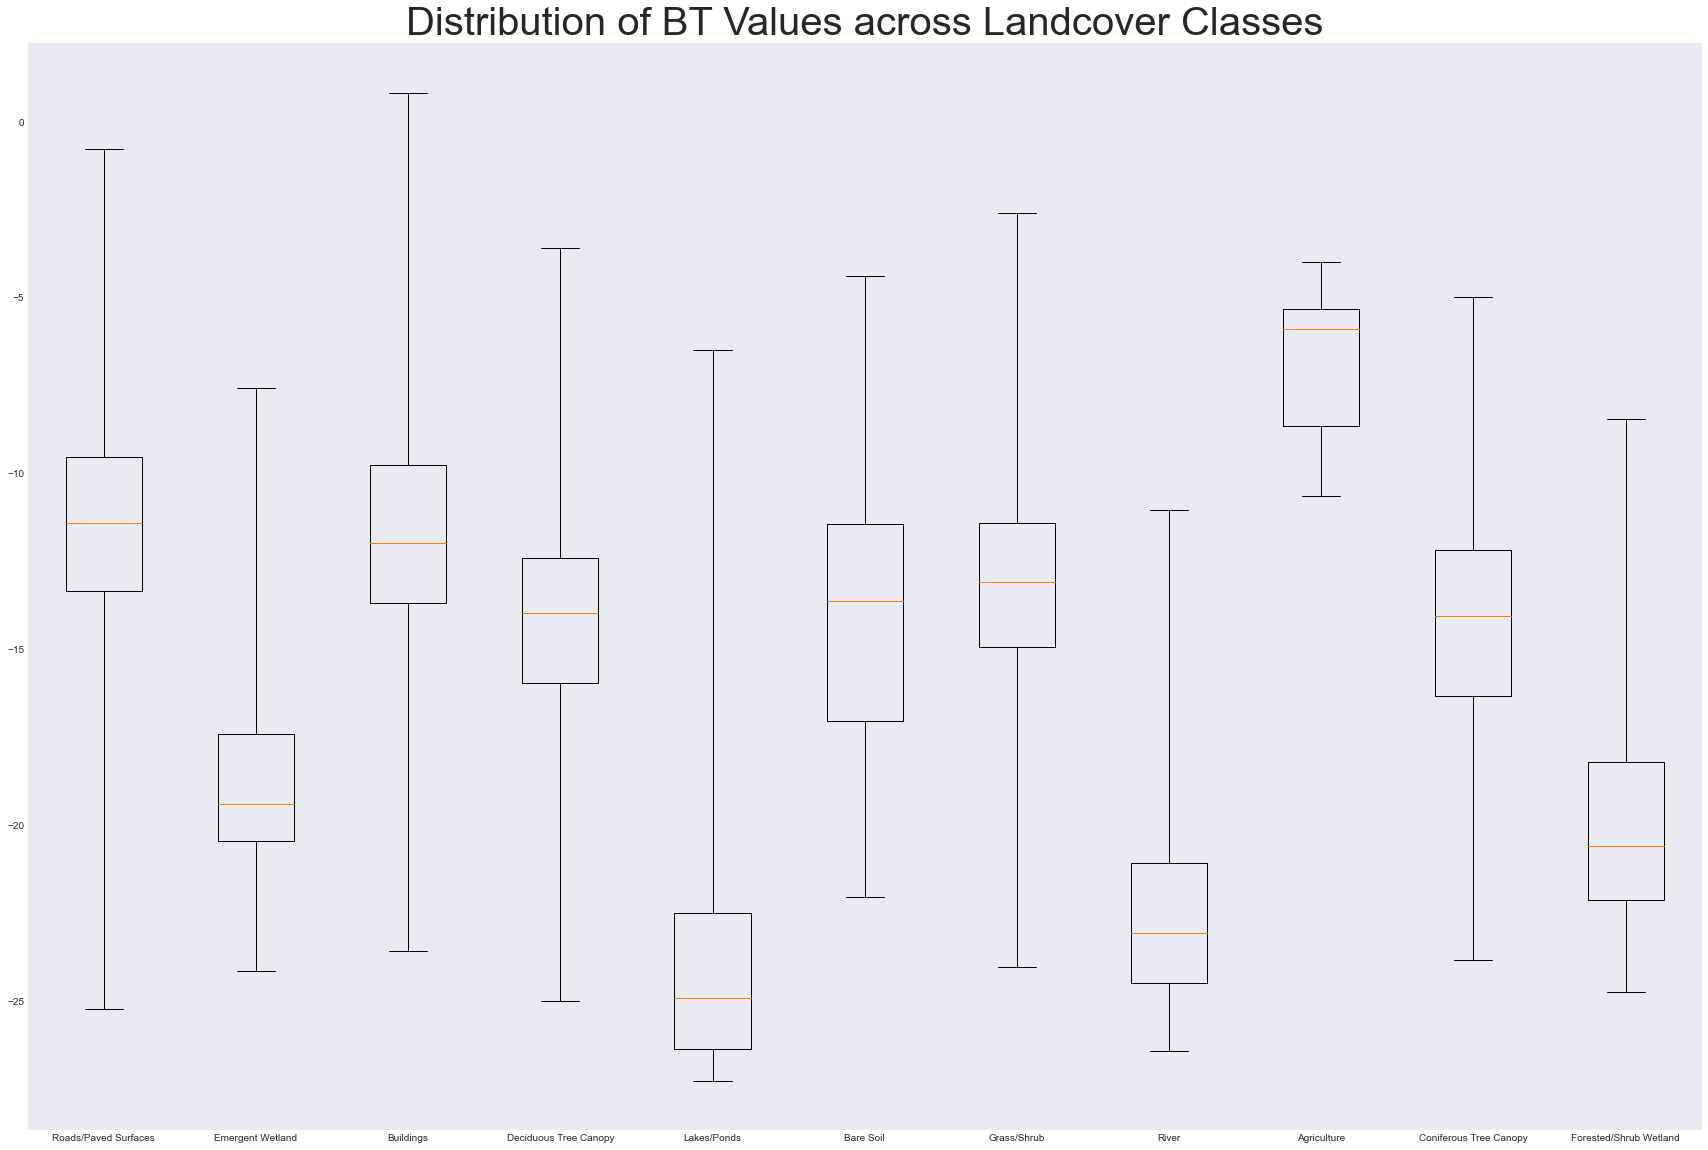

In [8]:
# Processing Data for Plotting
boxplot_data = final_results.drop(labels = ["mean", "std", "count"], axis = 0)

# Creating a Dictionary of the Summary Stats - for the bxp parameter in matplotlib
bxp_list = []

for (column_name, column_data) in boxplot_data.iteritems():
    lc_dict = {}
    
    value_list = [i for i in column_data.values]
    
    lc_dict["label"] = column_name
    lc_dict["whislo"] = value_list[0]
    lc_dict["whishi"] = value_list[1]
    lc_dict["q1"] = value_list[2]
    lc_dict["q3"] = value_list[3]
    lc_dict["med"] = value_list[4]
    
    bxp_list.append(lc_dict)

# Creating Plot
fig, axes = plt.subplots(1, 1, figsize=(30,20))
axes.bxp(bxp_list, showfliers = False)
axes.set_title("Distribution of BT Values across Landcover Classes", fontdict = {"fontsize":40})
plt.show()

In [9]:
# Cleaning Data for ANOVA
anova_table = results.reset_index(drop = True)
anova_table = anova_table.drop(labels = ["min", "max", "p25", "p75", "median"], axis = 1)
anova_table = anova_table.rename(columns={"Landcover" : "label", "count" : "n"})
                   
# Function to Run ANOVA from Summary Statistics
def anovaFromSummaryStats(df):
    """ Pass in DF with the follwing field names ['mean', 'std', 'n', 'label'] """
    
    # Checking DF Columns & Names
    try:
        "mean" in df.columns
        "std" in df.columns
        "n" in df.columns
        "label" in df.columns
        len(df.columns) == 4
    except:
        raise Exception("Dataframe must only contain the following columns ['mean', 'std', 'n', 'label'].")
    
    # Calculating Grand Mean
    grand_mean = df["mean"].mean()
    
    # Calculating New Values
    df["squared"] = (df["n"] * ((df["mean"] - grand_mean)**2))
    df["variance"] = (df["std"]**2)
    
    # Calculating Other Global Values
    dfB = (len(df["n"])-1)
    dfE = ((df["n"].sum()) - dfB)
    MSb = ((df["squared"].sum()) / (len(df["squared"])-1))
    MSe = ((df["variance"].sum()) / (len(df["variance"])))
    F = (MSb / MSe)
    p = (1 - f.cdf(F, dfB, dfE))
    
    # Displaying Results
    print("dfB=" + str(dfB) + "\n" +
         "dfE=" + str(dfE) + "\n" +
         "MSb=" + str(MSb) + "\n" +
         "MSe=" + str(MSe) + "\n" +
         "F=" + str(F) + "\n" +
         "p-value=" + str(p))

    
# Running Function  
anovaFromSummaryStats(anova_table)

dfB=10
dfE=211214
MSb=265477.2543497169
MSe=27834.656515213428
F=9.537651531809509
p-value=4.440892098500626e-16


## 4. Analysis of Results
Based on the results from the ANOVA test, along with the visual evidence from the boxplot, it is clear that there is a statistically significant difference amongst the mean LST values of different landcover classes. With a p-value of nearly 0, the evidence is very strong. In the field of statistics this would mean that we reject the null hypothesis (H<sub>0</sub>) which makes the assumption that there is no statistically significant differences between the means. Therefore we accept the alternative hypothesis (H<sub>a</sub>) which makes the assumption that there is some sort of statistically significant differences present between the means.

ANOVA does not tell us where these differences occur in the data, it simply tells us that these differences do exist. However, by visually inspecting the data, via the boxplots, it is clear to see that waterbodies have the lowest LST values, followed by wetlands and other green spaces, and lastly urban areas and agricultural areas sit at the top of the list. It should also be noted that agriculture does have a small n, so the results for that specific landcover class should be taken with this into consideration.